In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'drum-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2651414%2F4538065%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T233143Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2d6798facee20d0f535964d15dc6c495b667e5e38dd9f129eb252daa0cf487368be651485af4d11ed1adbc10e1a99ec2e8325158a0702bff1c00f66fa715cb358529eab8d6d92e5259762fbf238b8c429dfc8a27634730f82332e5391c2ca8bab6f3aacce057f6ed352ea23f8207cf127d280c5a679a1678fc71ef7b7ffb80e6dab2dfdc6409ad4838758841279b2daa9986ae80c8e97ba6eb3440358bd51d9f0667becc9026d644be48dadb71012ff3a475b91c130deaeed5b565e3298c40dfdbf1fd64644c43acda2cdb1b8ec1db4fd7e82954a64517983295a2605f1c1b68585be5a43c5e4914e6258bda33687eb11ae6584350b02a9c49609bdea47ae7d1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


This notebook classifies drumkit sounds by type using techniques from  Dipam Visani in his urban sounds classifier.

The dataset is from a personal sample library:

The categories are:
kick
snare
openhh
closedhh
percussion
cymbal


In [ ]:
#all the one time imports for this nb
import pandas as pd

from fastai.vision.all import *
from fastai.data.all import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from pathlib import Path
import os
import random
import IPython
#from tqdm import tqdm

from collections import OrderedDict

In [ ]:
audio_file = "../input/drum-dataset/Drum _classifier_dataset/kick/BD7500.WAV"
IPython.display.Audio(audio_file)

In [ ]:
#One time installs  - On AWS useconda_pytorch_p38 environment and add using ml.p3.2xlarge for this notebook
!pip install librosa
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1

# **Linear Spectrogram**

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


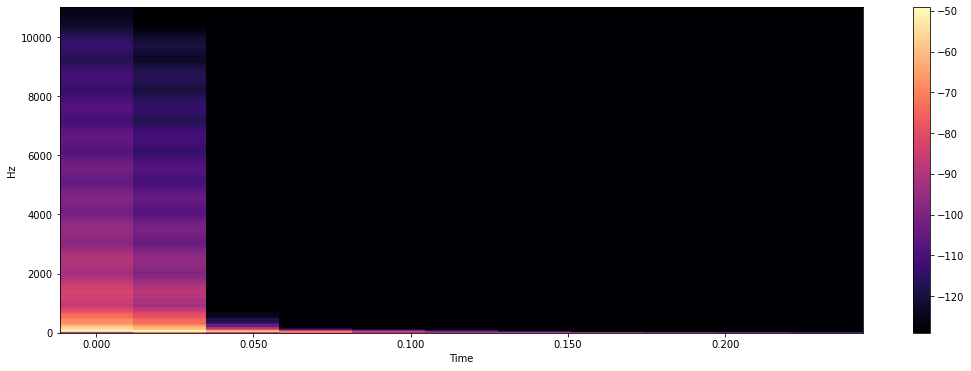

In [ ]:
samples, sample_rate = librosa.load(audio_file)
Ydb = librosa.amplitude_to_db(librosa.stft(samples), ref=sample_rate)
plt.figure(figsize=(18, 6))
librosa.display.specshow(Ydb, sr=sample_rate, x_axis='time', y_axis='linear')
plt.colorbar()

# Log Spectrogram

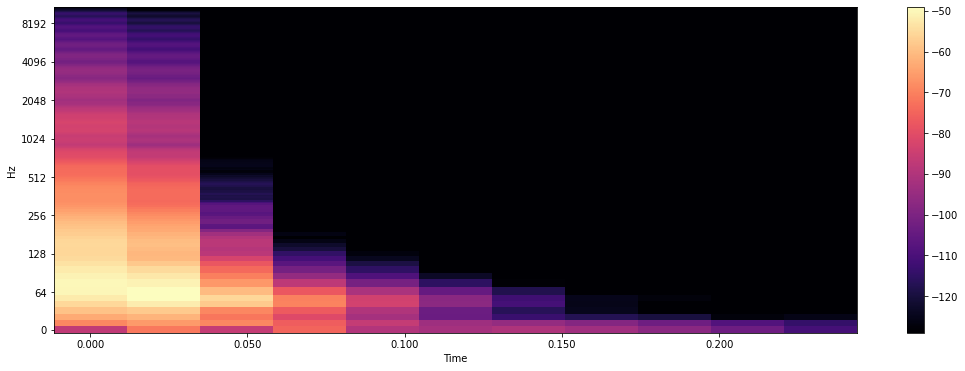

In [ ]:
plt.figure(figsize=(18, 6))
librosa.display.specshow(Ydb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

# Mel Spectrogram

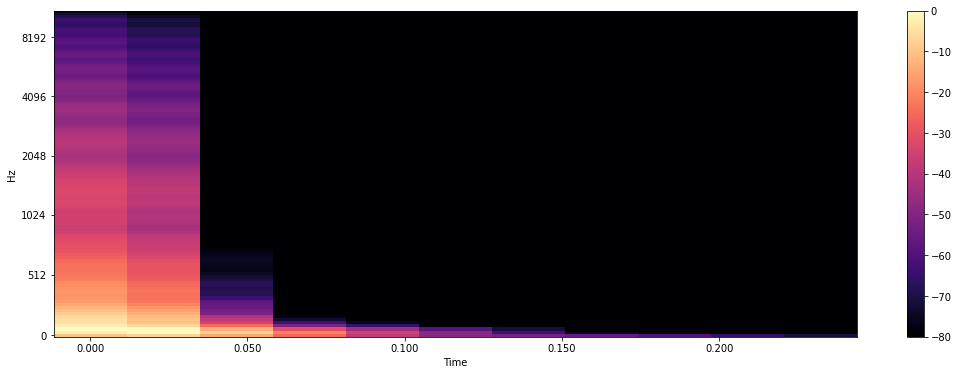

In [ ]:
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
Sdb = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(18, 6))
librosa.display.specshow(Sdb, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar()

# Create Spectrograms for Enitre Dataset

In [ ]:
audio_path = '../input/drum-dataset/Drum _classifier_dataset'  # un zipped source audio files are in this location as wav files
transform_store_path = 'DrumSoundTransforms/'  #destination folder for each transformed image state

In [ ]:
#make initial folders once
if not os.path.exists(transform_store_path):
    os.mkdir(transform_store_path)
    print('made folder ' + transform_store_path)

if not os.path.exists(transform_store_path +'linear_spectrogram'):
    os.mkdir(transform_store_path +'linear_spectrogram')
    print('made folder ' + transform_store_path +'linear_spectrogram' )

if not os.path.exists(transform_store_path +'log_spectrogram'):
    os.mkdir(transform_store_path +'log_spectrogram')
    print('made folder ' + transform_store_path +'log_spectrogram' )

if not os.path.exists(transform_store_path +'mel_spectrogram'):
    os.mkdir(transform_store_path +'mel_spectrogram')
    print('made folder ' + transform_store_path +'mel_spectrogram' )

made folder DrumSoundTransforms/
made folder DrumSoundTransforms/linear_spectrogram
made folder DrumSoundTransforms/log_spectrogram
made folder DrumSoundTransforms/mel_spectrogram


In [ ]:
for fold in os.listdir(audio_path):
    print(f'Processing fold {fold}')

    if not os.path.exists(transform_store_path+'linear_spectrogram/'+fold):
        os.mkdir(transform_store_path+'linear_spectrogram/'+fold)
    if not os.path.exists(transform_store_path+'log_spectrogram/'+fold):
        os.mkdir(transform_store_path+'log_spectrogram/'+fold)
    if not os.path.exists(transform_store_path+'mel_spectrogram/'+fold):
        os.mkdir(transform_store_path+'mel_spectrogram/'+fold)


    fold_path = os.path.join(audio_path, fold)
    for audio_file in os.listdir(fold_path):
        # print(audio_file)
        audio_file_path = os.path.join(fold_path, audio_file)
        samples, sample_rate = librosa.load(audio_file_path)  #create onces with librosa


        #plot for linear spectrogram - without axis, tight

        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        Ydb = librosa.amplitude_to_db(librosa.stft(samples), ref=sample_rate)
        LS = librosa.display.specshow(Ydb, sr=sample_rate, x_axis='time', y_axis='linear')
        audio_file = str(audio_file).replace('.WAV','.wav') # needed to screen out '.WAV's
        filename  = transform_store_path + 'linear_spectrogram/'+fold +'/'+ str(audio_file).split('/')[-1:][0].replace('.wav','.png')
        #print(filename)
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

        #plot for log  spectrogram - without axis, tight
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        LogS = librosa.display.specshow(Ydb, sr=sample_rate,x_axis='time', y_axis='log')
        audio_file = str(audio_file).replace('.WAV','.wav') # needed to screen out '.WAV's
        filename  = transform_store_path + 'log_spectrogram/'+ fold +'/'+ str(audio_file).split('/')[-1:][0].replace('.wav','.png')
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

        #plot for mel spectrogram - without axis, tight

        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        melS = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(melS, ref=np.max))
        audio_file = str(audio_file).replace('.WAV','.wav') # needed to screen out '.WAV's
        filename  = transform_store_path + 'mel_spectrogram/'+fold +'/'+ str(audio_file).split('/')[-1:][0].replace('.wav','.png')
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

Processing fold openhh
Processing fold kick
Processing fold closedhh
Processing fold cymbal
Processing fold toms
Processing fold snare


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1233
  return f(*args, **kwargs)


In [ ]:
failed = verify_images(get_image_files(transform_store_path))
failed.map(Path.unlink)
len(failed)

0

# Load Spectrograms into Dataloaders

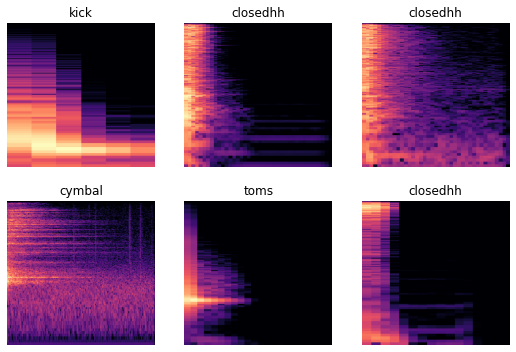

In [ ]:
path = './DrumSoundTransforms/log_spectrogram'

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

# Train the Model

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.527895,1.123772,0.500000,00:40


epoch,train_loss,valid_loss,error_rate,time
0,1.235296,0.687815,0.235294,00:56
1,0.863953,0.475416,0.205882,00:40
2,0.607287,0.371407,0.161765,00:34
3,0.449428,0.344460,0.176471,00:34
4,0.350052,0.332198,0.161765,00:34


Take a look at the confusion matrix

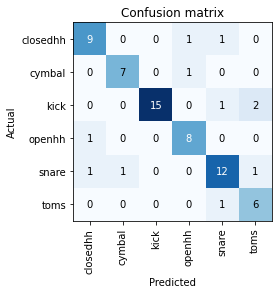

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Export the model

In [ ]:
learn.export('model.pkl')